In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")

In [5]:
data = pd.read_excel("Online Retail.xlsx")

In [7]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [15]:
data.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [14]:
data.dropna(subset = ["CustomerID"], inplace = True)

Yinelenen veri var mı diye kontrol edelim

In [16]:
data.duplicated().sum()

5225

5225 veri tekrarlanıyor. Bunları temizleyelim

In [18]:
data = data.drop_duplicates()
data.duplicated().sum()

0

In [19]:
data.describe()

,Quantity,UnitPrice,CustomerID
count,401604.000000,401604.000000,401604.000000
mean,12.183273,3.474064,15281.160818
std,250.283037,69.764035,1714.006089
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13939.000000
50%,5.000000,1.950000,15145.000000
75%,12.000000,3.750000,16784.000000
max,80995.000000,38970.000000,18287.000000


Quantity değerinde negatiflik söz konusu. Böyle bir şeyin olmasını istemiyoruz

In [20]:
data = data[(data["Quantity"]>0) & (data["UnitPrice"]>0)]
data.describe()

,Quantity,UnitPrice,CustomerID
count,392692.000000,392692.000000,392692.000000
mean,13.119702,3.125914,15287.843865
std,180.492832,22.241836,1713.539549
min,1.000000,0.001000,12346.000000
25%,2.000000,1.250000,13955.000000
50%,6.000000,1.950000,15150.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,8142.750000,18287.000000


In [21]:
data.shape

(392692, 8)

### <b><span style="color:green">Kohort Analizi</span></b>

In [25]:
def get_month(x):
    return dt.datetime(x.year,x.month,1)

data["InvoiceMonth"] = data["InvoiceDate"].apply(get_month)

#müşterinin ilk ürün satın aldığı tarihe göre gruplama
data["CohortMonth"] = data.groupby("CustomerID")["InvoiceMonth"].transform("min")
data.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,2011-12-01,2011-08-01
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,2011-12-01,2011-08-01
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,2011-12-01,2011-08-01
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,2011-12-01,2011-08-01
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France,2011-12-01,2011-08-01


In [28]:
def get_month_int(df,column):
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day

In [29]:
invoice_year, invoice_month, invoice_day = get_month_int(data, "InvoiceMonth")

cohort_year, cohort_month, cohort_day = get_month_int(data, "CohortMonth")

In [31]:
year_diff = invoice_year - cohort_year #son alışveriş yaptığı yıl ile ilk alışveriş yaptığı yıl
month_diff = invoice_month - cohort_month #son alışveriş yaptığı ay ile ilk alışveriş yaptığı ay

data["CohortIndex"] = year_diff * 12 + month_diff + 1

In [33]:
data.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth,CohortIndex
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,2010-12-01,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,2010-12-01,1


Her gruptan aktif müşterilerin sayısı

In [67]:
cohort_data = data.groupby(["CohortMonth","CohortIndex"])["CustomerID"].nunique()
cohort_data = pd.DataFrame(cohort_data).reset_index()

In [68]:
cohort_counts = cohort_data.pivot(index = "CohortMonth", columns="CohortIndex", values="CustomerID")
cohort_counts

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,885.0,324.0,286.0,340.0,321.0,352.0,321.0,309.0,313.0,350.0,331.0,445.0,235.0
2011-01-01,417.0,92.0,111.0,96.0,134.0,120.0,103.0,101.0,125.0,136.0,152.0,49.0,NaN
2011-02-01,380.0,71.0,71.0,108.0,103.0,94.0,96.0,106.0,94.0,116.0,26.0,NaN,NaN
2011-03-01,452.0,68.0,114.0,90.0,101.0,76.0,121.0,104.0,126.0,39.0,NaN,NaN,NaN
2011-04-01,300.0,64.0,61.0,63.0,59.0,68.0,65.0,78.0,22.0,NaN,NaN,NaN,NaN
2011-05-01,284.0,54.0,49.0,49.0,59.0,66.0,75.0,27.0,NaN,NaN,NaN,NaN,NaN
2011-06-01,242.0,42.0,38.0,64.0,56.0,81.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,188.0,34.0,39.0,42.0,51.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,169.0,35.0,42.0,41.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### <span style="color:green">Retention Rate</span>

In [72]:
cohort_size = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_size,axis=0)
retention.round(3) * 100 #sayıyı yüzde olarak göstereceğiz

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,100.0,36.6,32.3,38.4,36.3,39.8,36.3,34.9,35.4,39.5,37.4,50.3,26.6
2011-01-01,100.0,22.1,26.6,23.0,32.1,28.8,24.7,24.2,30.0,32.6,36.5,11.8,NaN
2011-02-01,100.0,18.7,18.7,28.4,27.1,24.7,25.3,27.9,24.7,30.5,6.8,NaN,NaN
2011-03-01,100.0,15.0,25.2,19.9,22.3,16.8,26.8,23.0,27.9,8.6,NaN,NaN,NaN
2011-04-01,100.0,21.3,20.3,21.0,19.7,22.7,21.7,26.0,7.3,NaN,NaN,NaN,NaN
2011-05-01,100.0,19.0,17.3,17.3,20.8,23.2,26.4,9.5,NaN,NaN,NaN,NaN,NaN
2011-06-01,100.0,17.4,15.7,26.4,23.1,33.5,9.5,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,100.0,18.1,20.7,22.3,27.1,11.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,100.0,20.7,24.9,24.3,12.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


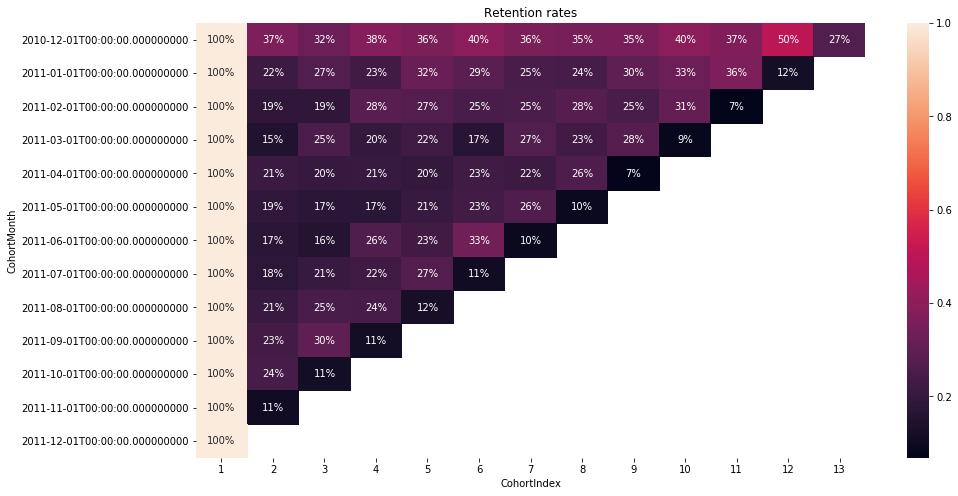

In [75]:
plt.figure(figsize = (15,8))
plt.title("Retention rates")
sns.heatmap(data = retention, annot=True, fmt=".0%")
plt.show()

> <b>Customer Retention</b>, tüm müşterilerin kaç tanesinin hala aktif olduğunu anlamak için çok yararlı bir metriktir.

> Retention, toplam müşteri sayısına kıyasla size aktif müşterilerin yüzdesini verir.

### Her grup için ortalama miktarı hesaplama

In [83]:
cohort_data = data.groupby(["CohortMonth","CohortIndex"])["Quantity"].mean()
cohort_data = pd.DataFrame(cohort_data).reset_index()
average_quantity = cohort_data.pivot(index ="CohortMonth",columns="CohortIndex",values="Quantity")
average_quantity.round(1)
average_quantity.index = average_quantity.index.date

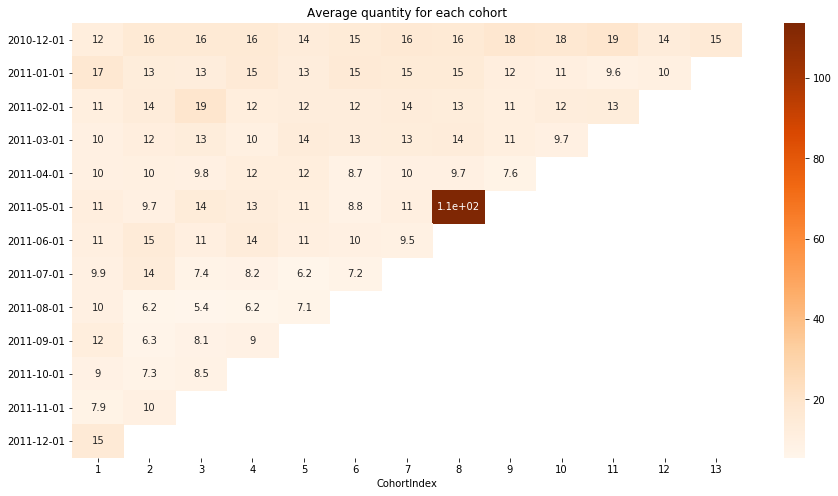

In [93]:
plt.figure(figsize=(15,8))
plt.title("Average quantity for each cohort")
sns.heatmap(data = average_quantity, annot=True, cmap="Oranges")
plt.show()

## <b><span style="color:red">Recency, Frequency and Monetary Değerlerini Hesaplama</span></b>

> * <b>Recency</b>, bir müşterinin son siparişinin ne zaman olduğu ile ilgilidir. Bir müşterinin son satın alma işlemini gerçekleştirmesinden bu yana geçen gün sayısı anlamına gelir
> * <b>Frequency</b>, belirli bir dönemdeki satın alma sayısı ile ilgilidir. 3 ay, 6 ay veya 1 yıl olabilir. Dolayısıyla bu değeri, bir müşterinin bir şirketin ürününü ne sıklıkta veya kaç kez kullandığıyla ilgili olarak anlayabiliriz.
> * <b>Monetary</b>, bir müşterinin o dönemde harcadığı toplam para miktarıdır. Bu nedenle, büyük harcama yapanlar MVP veya VIP gibi diğer müşterilerle farklılaşacaktır.

RFM değerleri çeşitli şekillerde gruplanabilir:
> <b> 1.Yüzdelik e.g. quantiles</b>

> <b>2.Pareto 80/20 cut</b>

> <b>3. Özel işletme bilgisine dayalı</b>

> Yüzdelik temelli gruplama yapacağız.

Yüzdelikleri hesaplama süreci:
* Müşterileri bu metriğe göre sıralayın,
* Müşterileri, önceden tanımlanmış eşit sayıda gruba ayırın,
* Her gruba bir etiket atayın

In [96]:
data["Total"] = data["UnitPrice"] * data["Quantity"]

print("Min Invoice Date:", data.InvoiceDate.dt.date.min(), "max Invoice Date:", data.InvoiceDate.dt.date.max())

data.head(3)

Min Invoice Date: 2010-12-01 max Invoice Date: 2011-12-09


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth,CohortIndex,Total
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,2010-12-01,1,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,1,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,2010-12-01,1,22.00


In [99]:
snap_date = data["InvoiceDate"].max() + dt.timedelta(days=1)
snap_date

Timestamp('2011-12-10 12:50:00')

burada +1 gün eklememizin sebebi o günü "şu an ki tarih" olarak kabul etmemizdir.

In [124]:
# bugünkü tarih ile en son işlem yapılan tarih arasındaki gün sayısı lambda fonskiyonu ile hesaplanmıştır.
rfm = data.groupby(["CustomerID"]).agg({"InvoiceDate":lambda x: (snap_date - x.max()).days,"InvoiceNo":"count","Total":"sum"})

rfm.rename(columns={"InvoiceDate":"Recency",
                   "InvoiceNo":"Frequency",
                   "Total":"Monetary"},inplace=True)
rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,182,4310.00
12348.0,75,31,1797.24
12349.0,19,73,1757.55
12350.0,310,17,334.40


Son zamanlarda daha az aktif olan <b>"Recency"</b> müşteriyi daha az müşteriden daha iyi değerlendireceğiz, çünkü her şirket müşterilerinin yeni olmasını istiyor

<b>"Frequency"</b> ve <b>"Monetary Değer"</b> yüksek etiketini derecelendireceğiz çünkü müşterinin daha fazla para harcamasını ve daha sık ziyaret etmesini istiyoruz (bu yenilikten farklı bir düzendir)

### <b><span style="color:green"> RFM Segmentini İnşa Etme</span></b>

In [125]:
r_labels = range(4,0,-1)
f_labels = range(1,5)
m_labels = range(1,5)

r_quartiles = pd.qcut(rfm["Recency"], q=4, labels = r_labels)
f_quartiles = pd.qcut(rfm["Frequency"], q=4, labels=f_labels)
m_quartiles = pd.qcut(rfm["Monetary"], q=4, labels=m_labels)
rfm = rfm.assign(R=r_quartiles,F=f_quartiles,M=m_quartiles)

In [127]:
rfm.head()

,Recency,Frequency,Monetary,R,F,M
CustomerID,,,,,,
12346.0,326,1,77183.60,1,1,4
12347.0,2,182,4310.00,4,4,4
12348.0,75,31,1797.24,2,2,4
12349.0,19,73,1757.55,3,3,4
12350.0,310,17,334.40,1,1,2


In [131]:
def add_rfm(x):
    return str(x['R']) + str(x['F']) + str(x['M'])

In [132]:
rfm['RFM_Segment'] = rfm.apply(add_rfm,axis=1 )
rfm['RFM_Score'] = rfm[['R','F','M']].sum(axis=1)
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
12346.0,326,1,77183.60,1,1,4,114,6.0
12347.0,2,182,4310.00,4,4,4,444,12.0
12348.0,75,31,1797.24,2,2,4,224,8.0
12349.0,19,73,1757.55,3,3,4,334,10.0
12350.0,310,17,334.40,1,1,2,112,4.0


### RFM Segmentinin Analizi
> En büyük RFM segmentleri Hedefleme veya diğer iş Uygulamaları için segmentleri kullanmadan önce segmentlerin boyutunu incelemek her zaman en iyi uygulamadır.

In [136]:
rfm.groupby(["RFM_Segment"]).size().sort_values(ascending=False)[:5]

RFM_Segment
444    450
111    381
344    217
122    206
211    179
dtype: int64

In [137]:
rfm[rfm["RFM_Segment"]=="111"].head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
12353.0,204,4,89.00,1,1,1,111,3.0
12361.0,287,10,189.90,1,1,1,111,3.0
12401.0,303,5,84.30,1,1,1,111,3.0
12402.0,323,11,225.60,1,1,1,111,3.0
12441.0,367,11,173.55,1,1,1,111,3.0


### RFM Puanı başına özet metrikler

In [138]:
rfm.groupby("RFM_Score").agg({"Recency":"mean",
                             "Frequency":"mean",
                             "Monetary":["mean","count"]}).round(1)

Recency Frequency Monetary      
             mean      mean     mean count
RFM_Score                                 
3.0         260.7       8.2    157.4   381
4.0         177.2      13.6    240.0   388
5.0         152.9      21.2    366.6   518
6.0          95.9      27.9    820.8   457
7.0          79.6      38.0    758.1   463
8.0          64.1      56.0    987.3   454
9.0          45.9      78.7   1795.1   414
10.0         32.4     110.5   2056.4   426
11.0         21.3     186.9   4062.0   387
12.0          7.2     367.8   9285.9   450

Müşterileri <b>Gold</b>, <b>Silver</b> ve <b>Bronze</b> segmentlerinde gruplandırmak için RFM puanını kullanın:

In [139]:
def segments(df):
    if df["RFM_Score"]>9:
        return "Gold"
    
    elif (df["RFM_Score"] >5) and (df["RFM_Score"]<=9):
        return "Silver"
    
    else: 
        return "Bronze"

In [140]:
rfm["General_Segment"] = rfm.apply(segments, axis=1)
rfm.groupby("General_Segment").agg({"Recency":"mean",
                                   "Frequency":"mean",
                                   "Monetary":["mean","count"]}).round(1)

Recency Frequency Monetary      
                   mean      mean     mean count
General_Segment                                 
Bronze            192.2      15.1    266.5  1287
Gold               20.1     225.6   5246.8  1263
Silver             72.0      49.4   1072.4  1788

## <b><span style="color:red">Kmeans Kümelenmesi için Veri Ön İşleme</span></b>

In [146]:
rfm_rfm = rfm[["Recency","Frequency","Monetary"]]
print(rfm_rfm.describe())

           Recency    Frequency       Monetary
count  4338.000000  4338.000000    4338.000000
mean     92.536422    90.523744    2048.688081
std     100.014169   225.506968    8985.230220
min       1.000000     1.000000       3.750000
25%      18.000000    17.000000     306.482500
50%      51.000000    41.000000     668.570000
75%     142.000000    98.000000    1660.597500
max     374.000000  7676.000000  280206.020000


Bu tablodan şu sorunu buluyoruz: Ortalama ve Varyans eşit değil.

Çözüm: Scikit-learn kütüphanesinden bir ölçekleyici kullanarak değişkenleri ölçeklendirme

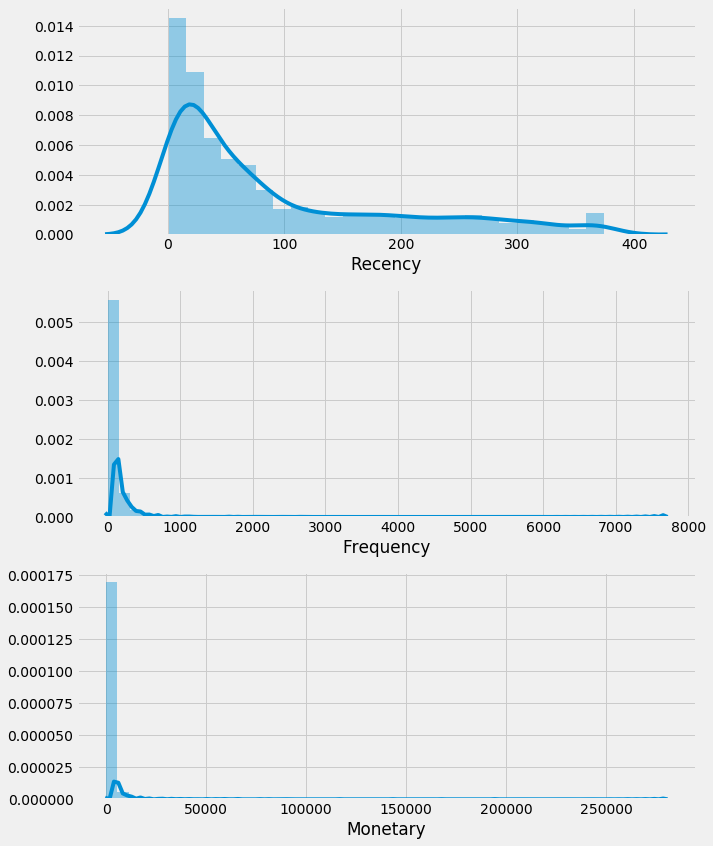

In [147]:
f,ax = plt.subplots(figsize=(10, 12))
plt.subplot(3, 1, 1); sns.distplot(rfm.Recency, label = 'Recency')
plt.subplot(3, 1, 2); sns.distplot(rfm.Frequency, label = 'Frequency')
plt.subplot(3, 1, 3); sns.distplot(rfm.Monetary, label = 'Monetary Value')
plt.style.use('fivethirtyeight')
plt.tight_layout()
plt.show()

Ayrıca başka bir sorun daha var: Değişkenlerin simetrik olmayan dağılımı (eğri veriler) 

<b>Çözüm:</b> Logaritmik dönüşüm (yalnızca pozitif değerler) çarpıklığı yönetir

Ön işleme adımlarını yapılandırma dizisini şu şekilde kullanırız:
> 1. Unskew veri - logaritmik dönüşümü
> 2. Aynı ortalama değerlere standartlaştırma
> 3. Aynı standart sapmaya göre ölçeklendirme
> 4. Kümeleme için kullanılacak ayrı bir dizi olarak depola

In [148]:
rfm_log = rfm[["Recency","Frequency","Monetary"]].apply(np.log, axis=1).round(3)

Şimdi tekrardan çizip görelim

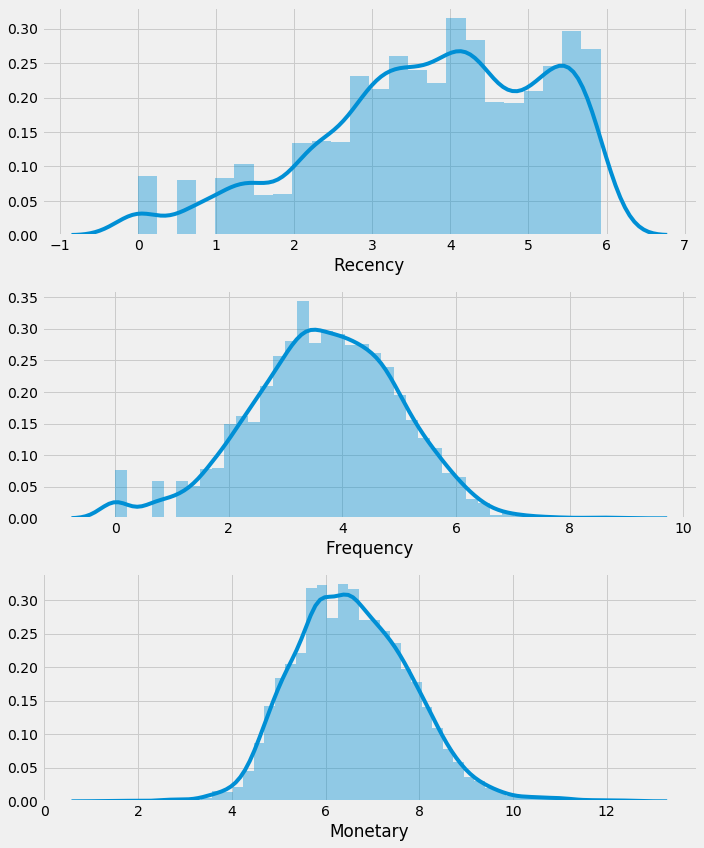

In [149]:
f,ax = plt.subplots(figsize=(10, 12))
plt.subplot(3, 1, 1); sns.distplot(rfm_log.Recency, label = 'Recency')
plt.subplot(3, 1, 2); sns.distplot(rfm_log.Frequency, label = 'Frequency')
plt.subplot(3, 1, 3); sns.distplot(rfm_log.Monetary, label = 'Monetary Value')
plt.style.use('fivethirtyeight')
plt.tight_layout()
plt.show()

## <b><span style="color:green">K-Ortalama Kümeleme Uygulaması</span></b>

Uygulanması gereken önemli adımlar:
> 1. Veri ön işleme
> 2. Kümelerin sayısını seçme
> 3. Ön işlenmiş veride K-means kümelemeyi uygula
> 4. Her bir küme için RFM değerlerinin ortalamasını analiz et

#### Preprocessing

In [151]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(rfm_log)
rfm_normalized = scaler.transform(rfm_log)
rfm_normalized

array([[ 1.40998159, -2.77997064,  3.70023933],
       [-2.14657818,  1.16036535,  1.41349442],
       [ 0.38364809, -0.17983348,  0.71994094],
       ...,
       [-1.1788923 , -0.89839206, -1.11262551],
       [-1.66273524,  2.20299461,  0.82219054],
       [-0.00454336,  0.43650655,  0.73737886]])

#### Kümelerin sayısını seçme
> 3 tip küme sayısı seçme yöntemi vardır:
> 1. Görsel methotlar - ELBOW kriteri
> 2. Matematiksel yöntem - SILHOUETTE katsayısı
> 3. Deneme-Yanılma

#### ELBOW methodu

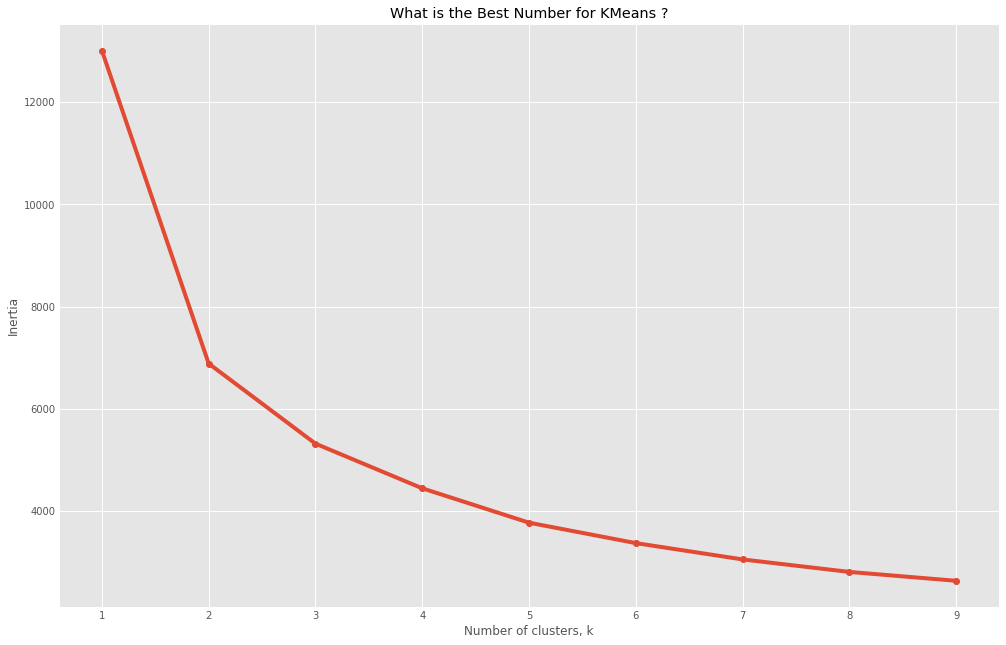

In [156]:
from sklearn.cluster import KMeans

ks = range(1,10)
inertias = []
for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(rfm_normalized)
    inertias.append(kmeans.inertia_)
    

f, ax = plt.subplots(figsize=(15, 10))
plt.plot(ks, inertias, '-o')
plt.xlabel('Number of clusters, k')
plt.ylabel('Inertia')
plt.xticks(ks)
plt.style.use('ggplot')
plt.title('What is the Best Number for KMeans ?')
plt.show()    

k=3'ü seçelim

In [159]:
kmeans = KMeans(n_clusters=3, random_state=1)
kmeans.fit(rfm_normalized)

cluster_labels = kmeans.labels_

rfm_kmeans3 = rfm_rfm.assign(K_Cluster=cluster_labels)
rfm_kmeans3.groupby('K_Cluster').agg({'Recency': 'mean','Frequency': 'mean',
                                         'Monetary': ['mean', 'count']}).round(0)

Recency Frequency Monetary      
             mean      mean     mean count
K_Cluster                                 
0            13.0     260.0   6554.0   957
1            69.0      65.0   1167.0  1858
2           171.0      15.0    293.0  1523

In [161]:
rfm_normalized = pd.DataFrame(rfm_normalized, index=rfm_rfm.index, columns=rfm_rfm.columns)
rfm_normalized["K_Cluster"] = kmeans.labels_
rfm_normalized["General_Segment"] = rfm["General_Segment"]
rfm_normalized.reset_index(inplace=True)

In [163]:
rfm_melt = pd.melt(rfm_normalized, id_vars=["CustomerID","General_Segment","K_Cluster"],
                  value_vars=["Recency","Frequency","Monetary"],
                  var_name="Metric",value_name="Value")
rfm_melt.head()

,CustomerID,General_Segment,K_Cluster,Metric,Value
0,12346.0,Silver,1,Recency,1.409982
1,12347.0,Gold,0,Recency,-2.146578
2,12348.0,Silver,1,Recency,0.383648
3,12349.0,Gold,1,Recency,-0.574961
4,12350.0,Bronze,2,Recency,1.375072


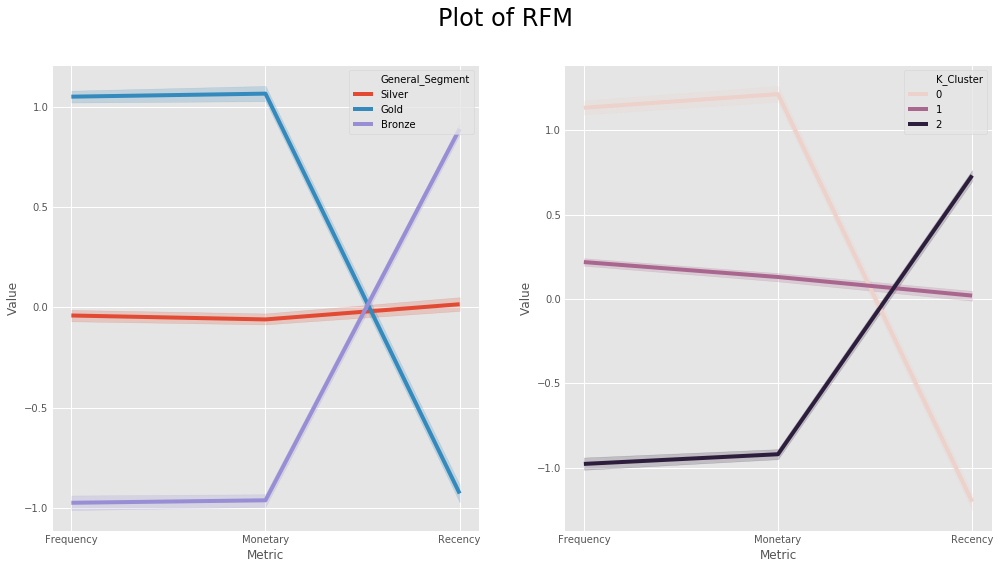

In [165]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 8))
sns.lineplot(x = 'Metric', y = 'Value', hue = 'General_Segment', data = rfm_melt,ax=ax1)

#  plot with K-Means
sns.lineplot(x = 'Metric', y = 'Value', hue = 'K_Cluster', data = rfm_melt,ax=ax2)

plt.suptitle("Plot of RFM",fontsize=24)
plt.show()

In [167]:
cluster_avg = rfm_kmeans3.groupby(['K_Cluster']).mean()
population_avg = rfm_rfm.mean()
relative_imp = cluster_avg / population_avg - 1
relative_imp.round(2)

,Recency,Frequency,Monetary
K_Cluster,,,
0,-0.86,1.87,2.20
1,-0.25,-0.28,-0.43
2,0.85,-0.84,-0.86


In [168]:
# the mean value in total 
total_avg = rfm.iloc[:, 0:3].mean()
# calculate the proportional gap with total mean
cluster_avg = rfm.groupby('General_Segment').mean().iloc[:, 0:3]
prop_rfm = cluster_avg/total_avg - 1
prop_rfm.round(2)

,Recency,Frequency,Monetary
General_Segment,,,
Bronze,1.08,-0.83,-0.87
Gold,-0.78,1.49,1.56
Silver,-0.22,-0.45,-0.48


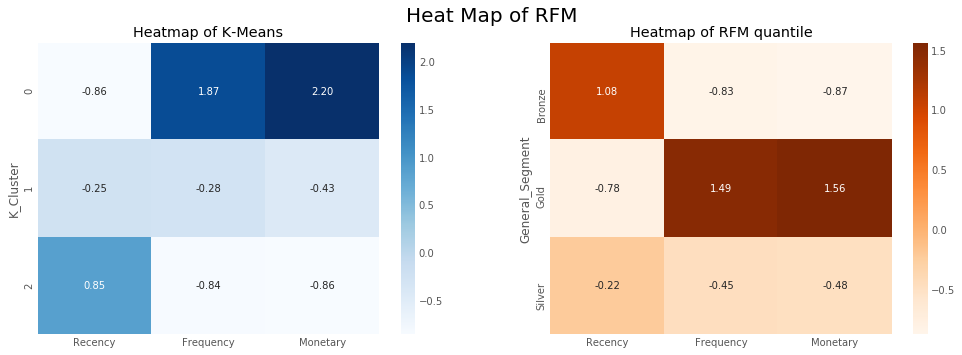

In [169]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 5))
sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='Blues',ax=ax1)
ax1.set(title = "Heatmap of K-Means")

# a snake plot with K-Means
sns.heatmap(prop_rfm, cmap= 'Oranges', fmt= '.2f', annot = True,ax=ax2)
ax2.set(title = "Heatmap of RFM quantile")

plt.suptitle("Heat Map of RFM",fontsize=20) #make title fontsize subtitle 

plt.show()

<b>Tenure</b> değişkeni ekleyerek RFM verilerini güncelleyebilirsiniz:
- <b>Tenure:</b> ilk işlemden bu yana geçen süre ، Müşterinin şirketle ne kadar süredir devam ettiğini tanımlar

Müşteri satın alma verilerinden RFM değerlerinin nasıl alınacağından bahsettik ve RFM miktarları ve K-Ortalama kümeleme yöntemleri ile iki tür segmentasyon yaptık.